In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import scipy.stats
import pandas

### Barrier Method

We will use the code of barrier method from the homework 3.

In [2]:
def g_t(t,v):
    s=0
    for i in range(2*m):
        s=s+np.log(b[i]-(A[i,:].reshape(1,-1)).dot(v))
    aux=np.dot(v.T,Q.dot(v))+np.dot(p.T,v)
    return(t*aux-s)

In [3]:
def grad_g_t(t,v):
    s=0
    for i in range(2*m):
        s=s+A[i,:].reshape(-1,1)/(b[i]-(A[i,:].reshape(1,-1)).dot(v))
    aux=(Q+Q.T).dot(v)+p
    return(t*aux+s)

In [4]:
def hess_g_t(t,v):
    s=0
    for i in range(2*m):
        s=s+(A[i,:].reshape(-1,1).dot(A[i,:].reshape(1,-1))/((b[i]-A[i,:].dot(v))**2))
    aux=Q+Q.T 
    return(t*aux+s)

In [5]:
def backtracking(alpha,beta,v,v_step,t):
    t_tilde=1
    while not((b-A.dot(v+t_tilde*v_step)>0).all()) or g_t(t,v+t_tilde*v_step)>g_t(t,v)+alpha*t_tilde*np.dot(grad_g_t(t,v).T,v_step):
        t_tilde=beta*t_tilde
    return t_tilde

In [6]:
def centering_step(Q,p,A,b,t,v0,eps):
    v_seq=[]
    v_seq.append(v0) 
    v=v0
    n_iter=0
    while True: 
        #compute Newton's step & decrement for v
        v_step=np.dot(-inv(hess_g_t(t,v)),grad_g_t(t,v))
        decr=-np.dot(grad_g_t(t,v).T,v_step)
        if (0.5*decr) <= eps:
            break 
        else :
            #backtracking line search 
            t1=backtracking(alpha,beta,v,v_step,t)
            #update
            v=v+t1*v_step
            v_seq.append(v)
            n_iter=n_iter+1
    return(n_iter, v_seq[-1])

In [7]:
def barr_method(Q,p,A,b,v0,eps,mu):
    v_seq=[]
    v_seq.append(v0) 
    v=v0
    t=1 
    n_iter2=[0]
    while True: 
        #centering step
        n_iter, v = centering_step(Q,p,A,b,t,v,eps)
        v_seq.append(v)
        n_iter2.append(n_iter2[-1]+n_iter)
        if (2*m)/t < eps:
            break 
        else :
            #update
            t=mu*t
        
    return(n_iter2, v_seq) 

In [8]:
#generation of data 

m=100
n=50

from sklearn.datasets import make_classification
X,y = make_classification(n_samples=m, n_features=n, n_classes=2)

for i in range(m):
    if y[i]==0:
        y[i]=-1
        
y=np.diag(y)

### Primal problem

In [9]:
c=0.1 
alpha=0.3
beta=0.8
eps=1e-6
mu=10

#initial point (must be strictly feasible because of log) 
v0=2*np.ones((m+n,1))
v0[:n]=0
#Q
Q=np.zeros((m+n,m+n))
Q[:n,:n]=0.5*np.eye(n)
#p
p=np.zeros((m+n,1))
p[n:m+n]=c*np.ones((m,1))

#A
A=np.zeros((2*m,m+n))
A[:m,:n]=-np.dot(y,X)  
A[:m,n:m+n]=-np.eye(m)
A[m:2*m,n:m+n]=-np.eye(m)
#b
b=np.zeros((2*m,1))
b[0:m]=-np.ones((m,1))

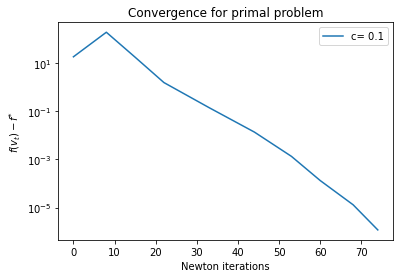

In [10]:
#plot the convergence

n_iter2, v_seq = barr_method(Q,p,A,b,v0,eps,mu)
v_star = v_seq[-1]
f_star=np.dot(v_star.T,Q.dot(v_star))+np.dot(p.T,v_star)
    
xx=n_iter2
xx.remove(xx[-1])
xx=(np.array(xx)).reshape(-1,1)
    
yy=[np.dot(v.T,Q.dot(v))+np.dot(p.T,v) - f_star for v in v_seq]
yy.remove(yy[-1])
yy=(np.array(yy)).reshape(-1,1)

plt.plot(xx,yy, label='c= ' + str(c))
plt.semilogy()
plt.xlabel('Newton iterations')
plt.ylabel('$f(v_{t})-f^{*}$')
plt.title('Convergence for primal problem')
plt.legend()

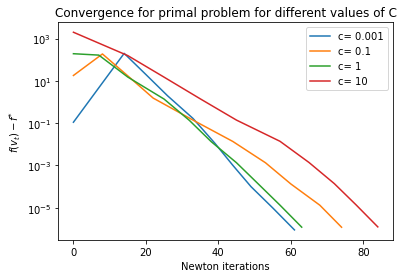

In [11]:
accuracy=[]
for c in [0.001, 0.1, 1, 10]:
    v0=2*np.ones((m+n,1))
    v0[:n]=0
    Q=np.zeros((m+n,m+n))
    Q[:n,:n]=0.5*np.eye(n)
    p=np.zeros((m+n,1))
    p[n:m+n]=c*np.ones((m,1))
    A=np.zeros((2*m,m+n))
    A[:m,:n]=-np.dot(y,X)  
    A[:m,n:m+n]=-np.eye(m)
    A[m:2*m,n:m+n]=-np.eye(m)
    b=np.zeros((2*m,1))
    b[0:m]=-np.ones((m,1))
    
    n_iter2, v_seq = barr_method(Q,p,A,b,v0,eps,mu)
    v_star = v_seq[-1]
    f_star=np.dot(v_star.T,Q.dot(v_star))+np.dot(p.T,v_star)
    
    #accuracy
    acc=0
    X_=X.T
    for i in range(m):
        if (y[i,i]*np.dot(v_star[0:n].T,X_[:,i].reshape(-1,1)))>0:
            acc=acc+1
    acc=acc/m
    accuracy.append(acc)
    
    #plot convergence 
    xx=n_iter2
    xx.remove(xx[-1])
    xx=(np.array(xx)).reshape(-1,1)
    
    yy=[np.dot(v.T,Q.dot(v))+np.dot(p.T,v) - f_star for v in v_seq]
    yy.remove(yy[-1])
    yy=(np.array(yy)).reshape(-1,1)
    
    plt.plot(xx, yy, label='c= ' + str(c))

plt.semilogy()
plt.xlabel('Newton iterations')
plt.ylabel('$f(v_{t})-f^{*}$')
plt.title('Convergence for primal problem for different values of C')
plt.legend()

In [12]:
accuracy=np.array(accuracy).reshape(4,1)
accuracy
pandas.DataFrame(data={'c=0.001':accuracy[0],'c=0.1':accuracy[1],'c=1':accuracy[2],'c=10':accuracy[3]})

,c=0.001,c=0.1,c=1,c=10
0,0.89,0.94,0.99,1.0


We notice that when c grows, the accuracy grows too. Indeed, when the regularization parameter is high, miss-classifications are less allowed. That's why, a good tradeoff would be to take a c not too large, not too small. 

### Dual problem

In [13]:
c=10

#initial point (must be strictly feasible because of log) 
v0=0.5*np.ones((m,1))
#Q
Q=0.5*np.dot(np.dot(y,X),np.dot(X.T,y))
#p
p=-np.ones((m,1))

#A
A=np.concatenate((np.eye(m), -np.eye(m)), axis=0)
#b
b=np.zeros((2*m,1))
b[0:m]=c*np.ones((m,1))

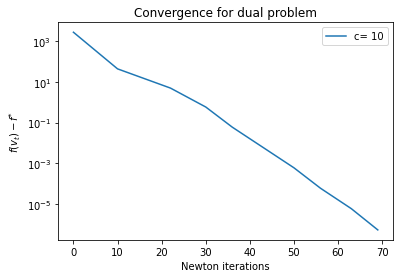

In [14]:
n_iter2, v_seq = barr_method(Q,p,A,b,v0,eps,mu)
v_star = v_seq[-1]
f_star=np.dot(v_star.T,Q.dot(v_star))+np.dot(p.T,v_star)
    
xx=n_iter2
xx.remove(xx[-1])
xx=(np.array(xx)).reshape(-1,1)
    
yy=[np.dot(v.T,Q.dot(v))+np.dot(p.T,v) - f_star for v in v_seq]
yy.remove(yy[-1])
yy=(np.array(yy)).reshape(-1,1)
    
plt.plot(xx, yy, label='c= ' + str(c))

plt.semilogy()
plt.xlabel('Newton iterations')
plt.ylabel('$f(v_{t})-f^{*}$')
plt.title('Convergence for dual problem')
plt.legend()

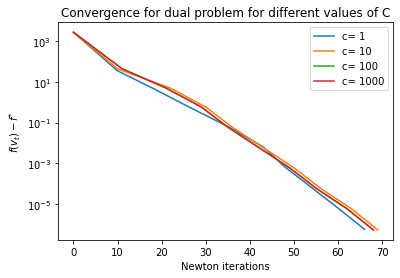

In [15]:
for c in [1, 10, 100, 1000]:
    v0=0.5*np.ones((m,1))
    Q=0.5*np.dot(np.dot(y,X),np.dot(X.T,y))
    p=-np.ones((m,1))
    A=np.concatenate((np.eye(m), -np.eye(m)), axis=0)
    b=np.zeros((2*m,1))
    b[0:m]=c*np.ones((m,1))
    
    n_iter2, v_seq = barr_method(Q,p,A,b,v0,eps,mu)
    v_star = v_seq[-1]
    f_star=np.dot(v_star.T,Q.dot(v_star))+np.dot(p.T,v_star)
    
    
    xx=n_iter2
    xx.remove(xx[-1])
    xx=(np.array(xx)).reshape(-1,1)
    
    yy=[np.dot(v.T,Q.dot(v))+np.dot(p.T,v) - f_star for v in v_seq]
    yy.remove(yy[-1])
    yy=(np.array(yy)).reshape(-1,1)
    
    plt.plot(xx, yy, label='c= ' + str(c))

plt.semilogy()
plt.xlabel('Newton iterations')
plt.ylabel('$f(v_{t})-f^{*}$')
plt.title('Convergence for dual problem for different values of C')
plt.legend()

For the dual problem, we notice that c has not a great impact on the convergence.